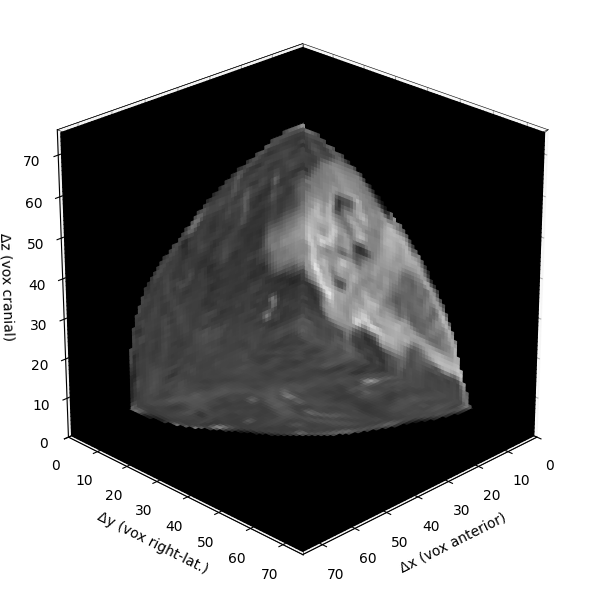

In [1]:
import os
import nibabel as nib
import mgmGrowth.tasks.superresolution.visualization.ortogonal as ov 
import mgmGrowth.tasks.superresolution.visualization.octant as oc

from pathlib import Path

ROOT = "/home/mariopasc/Python/Datasets/Meningiomas/BraTS"

# Buen meningioma "BraTS-MEN-00231-000"
patient = "BraTS-MEN-00231-000"
pulse = "t1c"
gt_nii = os.path.join(ROOT, "BraTS_Men_Train", patient, f"{patient}-{pulse}.nii.gz")
mm3_nii = os.path.join(ROOT, "SR", "3mm", "output_volumes", f"{patient}-{pulse}.nii.gz")
mm5_nii = os.path.join(ROOT, "SR", "5mm", "output_volumes", f"{patient}-{pulse}.nii.gz")
mm7_nii = os.path.join(ROOT, "SR", "7mm", "output_volumes", f"{patient}-{pulse}.nii.gz")

seg = os.path.join(ROOT, "BraTS_Men_Train", patient, f"{patient}-seg.nii.gz")
# fig = ov.plot_orthogonal_slices(nib.load(gt_nii).get_fdata(), (81, 135, 123), cmap="gray")
# fig.savefig(os.path.join(ROOT, f"{patient}-{pulse}-gt.png"), dpi=300)

offset = 10
volume = nib.load(gt_nii).get_fdata()
fig = oc.plot_octant(volume=volume,
                     slice_indices=(70 + offset, volume.shape[1]//2 + offset, 140 + offset), 
                     cmap="gray",
                     alpha=1.0,
                     segmentation=nib.load(seg).get_fdata(),
                     seg_alpha=0)